# Notebook for benchmarking GPU-acceleration tokenization

<font size="3">
Natural language processing (NLP) inference pipelines start with the tokenization process, which transforms natural language text into meaningful chunks. These smaller "sub-text" pieces are then converted into a numerical vectors to serve as inputs to deep learning (DL) models for making predictions for various NLP tasks like sentiment classifications, text summarization, and named-entity recognition. Practitioners have been making good progress in improving the performance of large language models, such as BERT, GPT-2, RoBERTa, DistilBert, XLNet, etc., and making them production-ready through the combination advanced optimization strategies (e.g., integer quantization), highly-optimized frameworks (e.g., TensorRT) as well as the increasing utilization of NVIDIA GPUs. However, the pre-processing (i.e., tokenization) part still does not benefit from the tremendous speedup provided by GPUs and the current efforts are mainly limited to CPU implementations. Therefore, the tokenization is unnecessarily slow and the main bottleneck of current end-to-end (E2E) NLP inference workflows, especially for scenarios involving extensive pre-inference processing. 

<br>

These problems motivated the NVIDIA RAPIDS team to develop a <a href="https://docs.rapids.ai/api/cudf/21.12/api_docs/api/cudf.core.subword_tokenizer.SubwordTokenizer.__call__.html"> GPU-accelerated subword tokenizer (GST)</a> that offers performance benefits that are crucial in serving large NLP models at scale. This GPU-based cuDF tokenizer is not only up to 483 faster than HuggingFace's (HF) Fast tokenizer, but also makes it possible to move the entire E2E workflow pipeline to GPU by avoiding expensive CPU copies, since the extracted tokens are kept in the GPU memory to be used in subsequent tensors as inputs to DL models.

The purpose of this notebook is to benchmark the GST against the HF's popular CPU-based <a href="https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizerFast
"> Fast BERT tokenizer</a>  developed in Rust programming language. To achieve this, we will utilize the Triton Inference Server to create an E2E inference workflow through two ensemble models that include either a GPU-based cuDF or a CPU-based HuggingFace tokenizer and the pre-trained <a href="https://huggingface.co/bert-base-uncased"> $\text{BERT}_{\text{Base}}$</a> model from HF's transformers library. Figure below shows the E2E workflow we will be using throughout this notebook.   

NVIDIA Triton is an open-source inference serving software that help standardize model deployment and execution. It supports all major DL frameworks, such as TensorFlow, PyTorch, NVIDIA TensorRT, ONNX, MXNet, etc., and work on any GPU- or CPU-based infrastructure. <a href="https://developer.nvidia.com/nvidia-triton-inference-server
">Here's</a> a great place to start if you are interested in learning more about the Triton.

</font>
<br><br>

<img src="notebook_images/ensemble_rapids_simple.jpg" width="300" height="400">

<font size="2">

**Fig. 1** The end-to-end inference workflow on Triton!
</font>










### Client Setup
<font size="3">
Triton Inference Server is available through the prebuilt Docker image from the <a href="https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
">NVIDIA GPU Cloud (NGC)</a>. For our benchmarks, we will need to build a Docker image that also includes RAPIDS and HuggingFace's transformer library. Luckily, we have already created a Docker file and all we need to use is to run the "build.sh" script to create the docker image, which will allow us to deploy our E2E RAPIDS and HuggingFace models with Triton.

```console
 bash build.sh
```

Once the Docker image is built, we can start the Triton Inference Server by running the container 

```console
 bash start_server
```

Here, we have two preprocessing (i.e. tokenization) models, rapids_tokenizer and hugginface_tokenizer and two ensemble models, end_to_end_rapids and end_to_end_huggingface, located in the models/ directory. Both ensemble models use the same $\text{BERT}_{\text{Base}}$ model for prediction and only differ in their preprocessing models which include either a RAPIDS (rapids_tokenizer) or a HuggingFace (huggingface_tokenizer) tokenizer.
</font>



In [ ]:
# !pip install nvidia-pyindex
# !pip install tritonclient[all]

### Import Libraries
<font size="3">
Clients can communicate with Triton using either an HTTP/REST ot GRPC protocol, ot by a C API. Herein, we use GRPC endpoints.
</font>

In [1]:
import numpy as np
import json

import grpc
from tritonclient.grpc import service_pb2
from tritonclient.grpc import service_pb2_grpc
import tritonclient.grpc as grpcclient
from functools import partial

###  Connect to the Triton End to End Model 

In [2]:
url='localhost:8001'

triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)

channel = grpc.insecure_channel(url)
grpc_stub = service_pb2_grpc.GRPCInferenceServiceStub(channel)

<font size="3">
Triton can simultaenously execurte multiple models or multiple instances of the same model using the same or different deep learning frameworks. Here, we connect to the ensemble model that uses the RAPIDS tokenizer and the BERT model in ONNX format and display its configuration defined in the config.pbtxt file under model directory to ensure that we our models are correct.
</font>

In [3]:
#preprocessing_model = 'end_to_end_onnx'
#preprocessing_model = 'rapids_tokenizer'
preprocessing_model = 'end_to_end_onnx_rapids'
request = service_pb2.ModelMetadataRequest(name=preprocessing_model,
                                           version='1')
response = grpc_stub.ModelMetadata(request)
print("model metadata:\n{}".format(response))

model metadata:
name: "end_to_end_onnx_rapids"
versions: "1"
platform: "ensemble"
inputs {
  name: "product_reviews"
  datatype: "BYTES"
  shape: -1
  shape: -1
}
outputs {
  name: "preds"
  datatype: "INT32"
  shape: -1
  shape: -1
}



### Define functions for tokenization and end-to-end inference
<font size="3">
The two following functions send a request from client side to Triton and receive a response from the server. The functions take two inputs: model name for Triton to execute and input for that model. Here, send_prepocess_request function can be used to execute one of the preprocessing models and takes the text as the input. And, the second function, send_inference_request, is appropriate for end_to_end (i.e., ensemble) models.
</font>

In [4]:
def send_preprocess_request(log_ar, model_name='rapids_tokenizer'):
    """ A function that sends a preprocessing request to Triton server
    Parameters
    ----------
    log_ar : list(str)
        The list of strings containing the input for the preprocessing model
    model_name : str, optional
        The name of the Triton model for preprocessing, by default 'rapids_tokenizer'

    Returns
    -------
    pb_utils.InferenceResponse
        A list of pb_utils.InferenceResponse. Length of this list matches the length of `requests` list
    """
    triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)
    input_grpc = grpcclient.InferInput("product_reviews",log_ar.shape,"BYTES")
    input_grpc.set_data_from_numpy(log_ar)

    outputs = []
    outputs.append(grpcclient.InferRequestedOutput('input_ids'))
    outputs.append(grpcclient.InferRequestedOutput('attention_mask'))

    
    output = triton_client.infer(model_name=model_name,
                               inputs=[input_grpc],
                              outputs=outputs)
    


    return output

In [5]:
def send_inference_request(log_ar, model_name='end_to_end_onnx_rapids'):
    """ A function that sends an end-to-end inference request to Triton server.
        The inference request contains tokenization and prediction through a deep-learning model

    Parameters
    ----------
    log_ar : list(str)
        The list of strings containing the input for the preprocessing model
    model_name : str, optional
        The name of the Triton model for inference, by default 'end_to_end_onnx_rapids'

    Returns
    -------
    pb_utils.InferenceResponse
        A list of pb_utils.InferenceResponse. Length of this list matches the length of `requests` list
    """
    triton_client = grpcclient.InferenceServerClient(url=url,verbose=False)
    input_grpc = grpcclient.InferInput("product_reviews",log_ar.shape,"BYTES")
    input_grpc.set_data_from_numpy(log_ar)
    outputs = []
    outputs.append(grpcclient.InferRequestedOutput('preds'))
    
    output = triton_client.infer(model_name=model_name,
                               inputs=[input_grpc],
                              outputs=outputs)
    

    return output


## Test if the inference is correct with both tokenizers
<font size="3">
Before starting our benchmarks, let's see if our setup is working correctly. To test this, we will send four different product reviews to the BERT model, which is fine tuned for the sentiment analysis, and check the model predictions are accurate. If we set up everything correctly, we expect Triton to return us a array with values [[1, 0, 1, ]], where 1 means the review is positive, and 0 means negative. This will also ensure that the both tokenizers produce the same result and are comparable.
</font>

##  Predictions

##### 1 is positive, 0 is negative

In [24]:
log_ls = ['The product is great', 'This product is bad','This product is good', 'This product is really bad']*1
log_ls = [l.encode('utf-8') for l in log_ls]
log_ar = np.array(log_ls).reshape(1,len(log_ls))
print(log_ar.shape, log_ar.squeeze().shape, type(log_ar))

(1, 4) (4,) <class 'numpy.ndarray'>


In [25]:
# RAPIDS
output = send_inference_request(log_ar,'end_to_end_onnx_rapids')
output.as_numpy('preds')

array([[1, 0, 1, 0]], dtype=int32)

In [26]:
# Huggingface
output = send_inference_request(log_ar,'end_to_end_onnx_huggingface')
output.as_numpy('preds')

array([[1, 0, 1, 0]], dtype=int32)

<font size="3">
It seems both ensemble models work as expected and we are ready to go!
</font>

## Benchmark RAPIDS vs Huggingface tokenizers

##### Utility functions 

<font size="3">
Before we begin our benchmark, there is one last thing that we need to do. Herein, we define two utility functions that will help us present our results. 

To obtain reliable results and reduce randomness in our benhcmark results, we will repeat each benchmark run many times. The following cell takes a list of runtimes and computes some meaningful statistics from those values. I shamelessly copy-pasted this from the github repository https://github.com/ELS-RD/transformer-deploy.git, which also contains other interesting examples such as optimizing transformers for inference using TensorRT.

The second utility function, plot_results&mdash;should be obvious :), just plots results as line graphs and attaches a table beneath it.

</font>

In [9]:
import time
from contextlib import contextmanager
from typing import Dict, List, Tuple, Union
def print_timings(name: str, timings: List[float]) -> None:
    """
    Format and print inference latencies.
    :param name: inference engine name
    :param timings: latencies measured during the inference
    """
    mean_time = 1e3 * np.mean(timings)
    std_time = 1e3 * np.std(timings)
    min_time = 1e3 * np.min(timings)
    max_time = 1e3 * np.max(timings)
    median, percent_95_time, percent_99_time = 1e3 * np.percentile(timings, [50, 95, 99])
    print(
        f"[{name}] "
        f"mean={mean_time:.4f}ms, "
        f"sd={std_time:.2f}ms, "
        f"min={min_time:.2f}ms, "
        f"max={max_time:.2f}ms, "
        f"median={median:.2f}ms, "
        f"95p={percent_95_time:.2f}ms, "
        f"99p={percent_99_time:.2f}ms"
    )

@contextmanager
def track_infer_time(buffer: List[int]) -> None:
    """
    A context manager to perform latency measures
    :param buffer: a List where to save latencies for each input
    """
    start = time.perf_counter()
    yield
    end = time.perf_counter()
    buffer.append(end - start)

### Plotting utility

In [10]:
import matplotlib.pyplot as plt

def plot_results(data, num_seqs, val_range, title='cuDF vs Huggingface', columns = ('Hugging Face', 'RAPIDS'), legend=['Hugging Face', 'cuDF'], row_label="batch_size", figsize=(8,6), dpi=150):
    """ A functions that plots runtimes and attaches a table beneath it

    Parameters
    ----------
    data : numpy.ndarray
        Input data array
    num_seqs : int
        number of sequences to plot
    val_range : value range
        Range of values to plot
    title : str, optional
        The figure title, by default 'cuDF vs Huggingface'
    columns : tuple, optional
        Captions for the rows of the table, by default ('Hugging Face', 'RAPIDS')
    legend : list, optional
        Features being plotted, by default ['Hugging Face', 'cuDF']
    row_label : str, optional
        The x-axis of the plot. Also, the rows of the table., by default "batch_size"
    figsize : tuple, optional
        The figure size: (width, heigth), by default (8,6)
    dpi : int, optional
        Resolution at which the figure will be saved, by default 150
    """
    from matplotlib.pyplot import figure
    
    figure(figsize=figsize, dpi=dpi)

    dataf = np.flip(data, axis=0)
    
    columns = columns
    rows =  [row_label + ': %d' % num_seq for num_seq in num_seqs]

    
    values = val_range 
    #values = np.arange(0, np.amax(data), np.amax(data)/10)
    value_increment = 1

    # Get some pastel shades for the colors
    colors = plt.cm.RdBu(np.linspace(0.15, 0.95, len(rows)))
    n_rows = len(data)
  
    index = np.arange(len(columns)) + 0.3
    bar_width = 0.4


    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(columns))
    linecolors=["r", "b", "g", "k"]
    for i in range(data.shape[1]):
        datamarker = linecolors[i]+'-'
        print('shape: ', data.shape[1])
        plt.plot(np.arange(0, n_rows), data[:, i], datamarker, alpha=0.25)
        #plt.plot(np.arange(0, n_rows), data[:, 1], 'b-', alpha=0.25)

    plt.grid(alpha=0.5)
    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        for i in range(data.shape[1]):
            datamarker = linecolors[i]+'.'
            #plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
            plt.plot(row, data[row, i], datamarker, markersize=12)
            #plt.plot(row, data[row, 1], 'b.', markersize=12)
        
        #cell_text.append(['%.2f' % (x) for x in y_offset])
        cell_text.append(['%.2f' % (x) for x in dataf[row]])
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    cell_text.reverse()

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom',
                          cellLoc='center')

    the_table.set_fontsize(7)

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.ylabel("Time (ms)", fontsize=10)
    plt.yticks(values * value_increment, ['%d' % val for val in values])
    plt.xticks([])
    plt.title(title, fontsize=8, fontweight='bold')
    

    from matplotlib.font_manager import FontProperties
    # Make table labels bold
    for (row, col), cell in the_table.get_celld().items():
        if (row == 0) or (col == -1):
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))

    plt.legend(legend, fontsize=6.5)
    plt.show()

### Prepare Input 
##### Generate input of variable number of sequences and seq length

<font size="3">
For our benchmark, we will generate long text sequences using the function below. This function takes a sentence and makes it longer using the lenfac parameters as well as duplicates is num_seq times to generate multiple sentences/sequences
</font>

In [27]:
def prepare_input(sentence='This product is great', lenfac=100, num_seq=100):
    """A function that repeats the input sentence in two axes.

    Parameters
    ----------
    sentence : str, optional
        An input sentence, by default 'This product is great'
    lenfac : int, optional
        The factor that determines how many times the sentence should be repeated long the first dimension.
            This does not generates another sentence, but rather makes the existing one longer. By default 100
    num_seq : int, optional
        Factor to replicate the elongated sentence, by default 100
        This just repeats the sentence elongate by lenfac parameter to create a batch.

    Returns
    -------
    np.array
        An array of str (sentences)
    """

    log_txt = sentence * lenfac
    log_ls = [log_txt] * num_seq
    log_ls = [l.encode('utf-8') for l in log_ls]
    
    return np.array(log_ls).reshape(1,len(log_ls))

## Run the benchmark: with procedurally generated data


## Fixed Seq length, variable batch size

<font size="3">
In our first benchmark, we will use input text with fixed-length sentences (256 words) and in each run we will send a different number of sequences (i.e., sentences) to our preprocessing and ensemble models. Here, the array num_seqs denotes how many sequences we will process for each benchmark run, which will also determine our batch size. As you can see below, we will be testing all models with 2, 10, 100, and 1000 input sentences of 256-word long.

We are running 10 warm up round before each benchmark run and repeat each benchmark test 10 times.
</font>

In [12]:
# dictionary for the benchmark results
results = {}

# Sequence length
lenfac = 64 # seq_length is 256

# Benchmark parameters
num_warmup_runs = 10
num_bench_runs = 10

# Number of sequences to process: batch size
num_seqs= [2, 10, 100, 1000]
#num_seqs = [2**x for x in range(1,11)]

# Run a preprocess (tokenization) or an end-to-end inference request
modes = ["preprocess", "inference"] # do not put this in the loop to avoid if conditions

# Backends to try: cudf (RAPIDS) vs hugf (Hugging Face)
backends = ["rapids", "huggingface"]


# Number of experiments
num_exp = len(num_seqs)
# Number of modes
num_modes = len(modes)
# Number of backends
num_backends = len(backends)


for num_seq in num_seqs:
    # Input for the current benchmark
    #log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    
    for backend in backends:
        
        # Preprocessing
        mode = modes[0]
        tag = "{}_{}_{}".format(mode, backend, num_seq)  
        model_name = "{}_tokenizer".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)

        # Benchmark
        time_buffer = []        
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):                
                output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)
        results[tag] = time_buffer

        # Inference
        mode = modes[1]
        tag = "{}_{}_{}".format(mode, backend, num_seq)            
        model_name = "end_to_end_onnx_{}".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_inference_request(log_ar, model_name=model_name)
        
        # Benchmark
        time_buffer = []
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):
                output = send_inference_request(log_ar, model_name=model_name)
        results[tag] = time_buffer        

##### Benchmark statistics

In [13]:
for name, time_buffer in results.items():
    print_timings(name=name, timings=time_buffer)

[preprocess_rapids_2] mean=3.8654ms, sd=0.13ms, min=3.55ms, max=4.02ms, median=3.90ms, 95p=4.00ms, 99p=4.01ms
[inference_rapids_2] mean=9.8098ms, sd=0.22ms, min=9.54ms, max=10.12ms, median=9.79ms, 95p=10.12ms, 99p=10.12ms
[preprocess_huggingface_2] mean=3.7202ms, sd=0.24ms, min=3.46ms, max=4.11ms, median=3.71ms, 95p=4.04ms, 99p=4.10ms
[inference_huggingface_2] mean=9.0618ms, sd=0.16ms, min=8.80ms, max=9.33ms, median=9.06ms, 95p=9.28ms, 99p=9.32ms
[preprocess_rapids_10] mean=5.4702ms, sd=0.36ms, min=5.00ms, max=6.20ms, median=5.39ms, 95p=6.03ms, 99p=6.16ms
[inference_rapids_10] mean=17.2983ms, sd=0.24ms, min=16.87ms, max=17.76ms, median=17.29ms, 95p=17.64ms, 99p=17.73ms
[preprocess_huggingface_10] mean=6.1618ms, sd=0.32ms, min=5.84ms, max=6.85ms, median=6.07ms, 95p=6.68ms, 99p=6.81ms
[inference_huggingface_10] mean=18.2690ms, sd=0.44ms, min=17.66ms, max=19.15ms, median=18.27ms, 95p=18.97ms, 99p=19.11ms
[preprocess_rapids_100] mean=8.3007ms, sd=0.38ms, min=7.64ms, max=9.00ms, median=8.36

In [14]:
# prepare the plot data
times = 1e3 * np.mean(np.array(list(results.values())), axis=1).reshape((num_modes * num_exp, num_backends))
rapids_pre_times = times[::2, 0].reshape((-1,1))
rapids_inf_times = times[::2, 1].reshape((-1,1))
huggingface_pre_times = times[1::2, 0].reshape((-1,1))
huggingface_inf_times = times[1::2, 1].reshape((-1,1))    

### Plot results



<font size="3">
The first graph below compares the run times for the GPU-based RAPIDS and CPU-based Hugging Face tokenizers. Also, the table presents average run time of 10 benchmark runs in millisconds. As is apparent from the image, the performance gap between two increases with increasing batch size, meaning GPUs are being more efficient with increasing data size. This is particularly important for inference workloads that process large texts. The most interesting thing to note here is the relatively small batch size of 100, which shows that GPU-accelerated tokenization speeds up inference workflows even with small texts. This might be crucial for application that perform online inference.
</font>

shape:  2
shape:  2


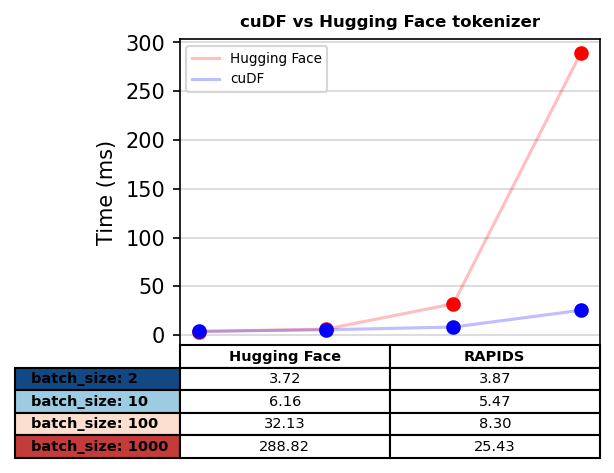

In [15]:

# cuDF vs Hugging Face: tokenization 
value_range = np.arange(0, 350, 50)
plotdata_pre = np.concatenate((huggingface_pre_times, rapids_pre_times), axis=1)
title = 'cuDF vs Hugging Face tokenizer'
columns = ('Hugging Face', 'RAPIDS')
legend=['Hugging Face', 'cuDF']
plot_results(plotdata_pre, num_seqs, value_range, title, columns, legend, figsize=(4,3))


<font size="3">
The graph below compares the run times of E2E models with the GPU-based RAPIDS and CPU-based Hugging Face tokenizers. Here, runtimes include the tokenization time and the time it takes to run a forward pass through the BERT model. As the image shows, the BERT prediction dominates the runtime; however, we still obtain a 250ms speed up by running the tokenization in GPU with a batch size of 1000.
</font>

shape:  2
shape:  2


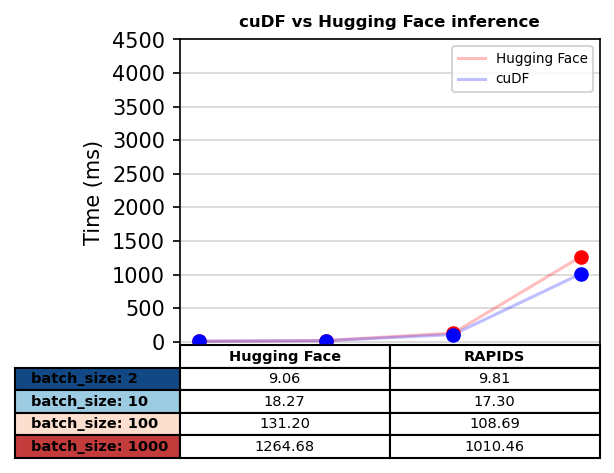

In [16]:
# cuDF vs Hugging Face: inference
value_range = np.arange(0, 5000, 500)
plotdata_inf = np.concatenate((huggingface_inf_times, rapids_inf_times), axis=1)
title = 'cuDF vs Hugging Face inference'
columns = ('Hugging Face', 'RAPIDS')
plot_results(plotdata_inf, num_seqs, value_range, title, columns, legend, figsize=(4,3))

<font size="3">
The final plot .
</font>

shape:  2
shape:  2


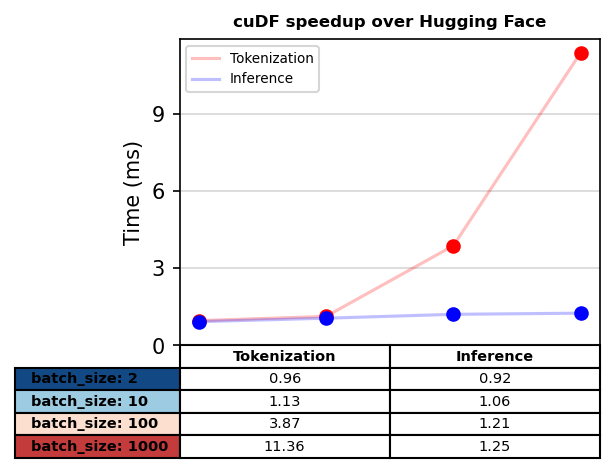

In [17]:
# cuDF vs Hugging Face: speedup
value_range = np.arange(0, 12, 3)
speedups = np.concatenate(((huggingface_pre_times/rapids_pre_times).reshape(-1,1), (huggingface_inf_times/rapids_inf_times).reshape(-1,1)), axis=1)
columns = ('Tokenization', 'Inference')
title = 'cuDF speedup over Hugging Face'
legend=['Tokenization', 'Inference']
plot_results(speedups, num_seqs, value_range, title, columns, legend, figsize=(4,3))

## Fixed Batch size, variable sequence length

In [18]:
# dictionary for the benchmark results
results_pre = {}

# Sequence length
#lenfacs =  [2, 10, 100, 1000]
#lenfacs =  [2, 4, 8, 16]
lenfacs = [2**x for x in range(1,11)]

# Benchmark parameters
num_warmup_runs = 10
num_bench_runs = 10

# Number of sequences to process: batch size
num_seq = 256

# Run a preprocess (tokenization) or an end-to-end inference request
modes = ["preprocess"] # do not put this in the loop to avoid if conditions

# Backends to try: cudf (RAPIDS) vs hugf (Hugging Face)
backends = ["rapids", "huggingface"]

# Number of experiments
num_exp = len(lenfacs)
# Number of modes
num_modes = len(modes)
# Number of backends
num_backends = len(backends)

for lenfac in lenfacs:
    # Input for the current benchmark
    #log_ar = prepare_input(lenfac=lenfac, num_seq=num_seq)
    log_ar = prepare_input("Good", lenfac=lenfac, num_seq=num_seq)
    
    for backend in backends:
        
        # Preprocessing
        mode = modes[0]
        tag = "{}_{}_{}".format(mode, backend, lenfac)  
        model_name = "{}_tokenizer".format(backend)
        
        # Warm up
        for _ in range(num_warmup_runs):
            output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)

        # Benchmark
        time_buffer = []        
        for _ in range(num_bench_runs):
            with track_infer_time(time_buffer):                
                output = send_preprocess_request(log_ar.squeeze(), model_name=model_name)
        results_pre[tag] = time_buffer

##### Benchmark statistics

In [19]:
for name, time_buffer in results_pre.items():
    print_timings(name=name, timings=time_buffer)

[preprocess_rapids_2] mean=26.2462ms, sd=0.97ms, min=24.95ms, max=28.15ms, median=26.41ms, 95p=27.73ms, 99p=28.07ms
[preprocess_huggingface_2] mean=28.0091ms, sd=1.94ms, min=25.68ms, max=30.74ms, median=27.35ms, 95p=30.54ms, 99p=30.70ms
[preprocess_rapids_4] mean=28.5722ms, sd=0.83ms, min=27.45ms, max=29.89ms, median=28.32ms, 95p=29.72ms, 99p=29.86ms
[preprocess_huggingface_4] mean=27.7010ms, sd=1.57ms, min=26.06ms, max=30.48ms, median=26.80ms, 95p=30.32ms, 99p=30.45ms
[preprocess_rapids_8] mean=31.0958ms, sd=0.88ms, min=29.89ms, max=32.27ms, median=31.00ms, 95p=32.20ms, 99p=32.25ms
[preprocess_huggingface_8] mean=30.7164ms, sd=1.59ms, min=28.81ms, max=33.05ms, median=30.43ms, 95p=32.85ms, 99p=33.01ms
[preprocess_rapids_16] mean=33.7892ms, sd=1.29ms, min=32.73ms, max=36.38ms, median=33.17ms, 95p=35.97ms, 99p=36.30ms
[preprocess_huggingface_16] mean=42.1094ms, sd=5.70ms, min=38.17ms, max=58.08ms, median=39.59ms, 95p=51.74ms, 99p=56.81ms
[preprocess_rapids_32] mean=37.9352ms, sd=1.19ms, 

In [20]:
# prepare the plot data
times = 1e3 * np.mean(np.array(list(results_pre.values())), axis=1).reshape((num_modes * num_exp, num_backends))
rapids_pre_times = times[:, 0].reshape((-1,1))
huggingface_pre_times = times[:, 1].reshape((-1,1))

shape:  2
shape:  2


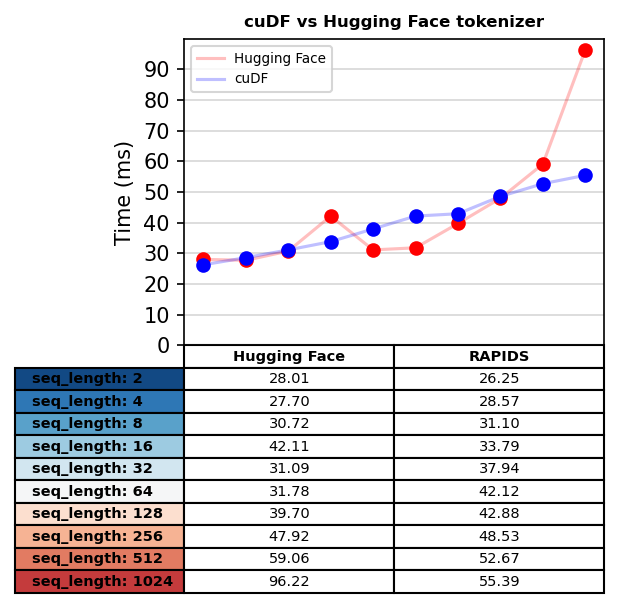

In [21]:

value_range = np.arange(0, 100, 10)
plotdata_pre = np.concatenate((huggingface_pre_times, rapids_pre_times), axis=1)
title = 'cuDF vs Hugging Face tokenizer'
columns = ('Hugging Face', 'RAPIDS')
legend=['Hugging Face', 'cuDF']
rowlabel = "seq_length"
plot_results(plotdata_pre, lenfacs, value_range, title, columns, legend, rowlabel, figsize=(4,3))

shape:  1


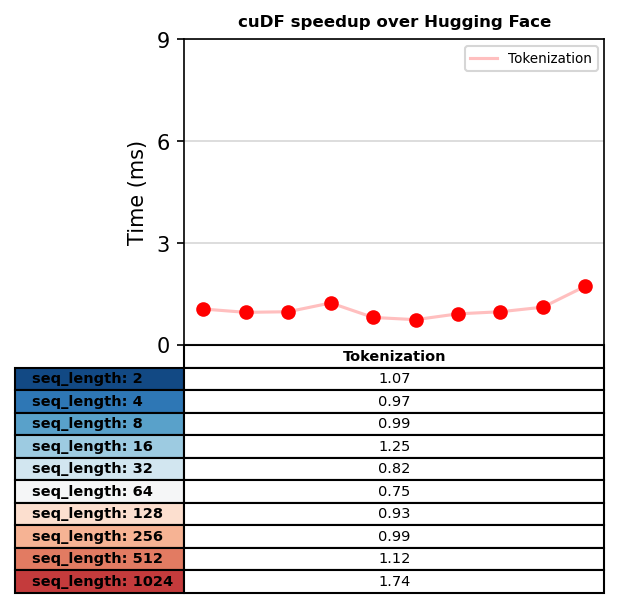

In [22]:
value_range = np.arange(0, 12, 3)
speedups = (huggingface_pre_times/rapids_pre_times).reshape(-1,1)
columns = ('Tokenization','')
title = 'cuDF speedup over Hugging Face'
legend=['Tokenization']
rowlabel = "seq_length"
plot_results(speedups, lenfacs, value_range, title, columns, legend, rowlabel, figsize=(4,3))